In [1]:
!pip install easyfsl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 42 kB 481 kB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import Omniglot
from torchvision.models import resnet18
from tqdm import tqdm

from easyfsl.samplers import TaskSampler
from easyfsl.utils import plot_images, sliding_average

# NB: background=True selects the train set, background=False selects the test set
# It's the nomenclature from the original paper, we just have to deal with it


In [4]:
image_size = 28
data_dir = '../data/omniglot'

# train set is list of (x, y) 
# where x is single image and y is label corresponding to it.
train_set = Omniglot(
    root=data_dir,
    background=True,
    transform=transforms.Compose(
        [
            transforms.Grayscale(num_output_channels=3),
            transforms.RandomResizedCrop(image_size),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
        ]
    ),
    download=True,
)
test_set = Omniglot(
    root=data_dir,
    background=False,
    transform=transforms.Compose(
        [
            # Omniglot images have 1 channel, but our model will expect 3-channel images
            transforms.Grayscale(num_output_channels=3),
            transforms.Resize([int(image_size * 1.15), int(image_size * 1.15)]),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),
        ]
    ),
    download=True,
)

  0%|          | 0/9464212 [00:00<?, ?it/s]

Extracting ../data/omniglot/omniglot-py/images_background.zip to ../data/omniglot/omniglot-py


  0%|          | 0/6462886 [00:00<?, ?it/s]

Extracting ../data/omniglot/omniglot-py/images_evaluation.zip to ../data/omniglot/omniglot-py


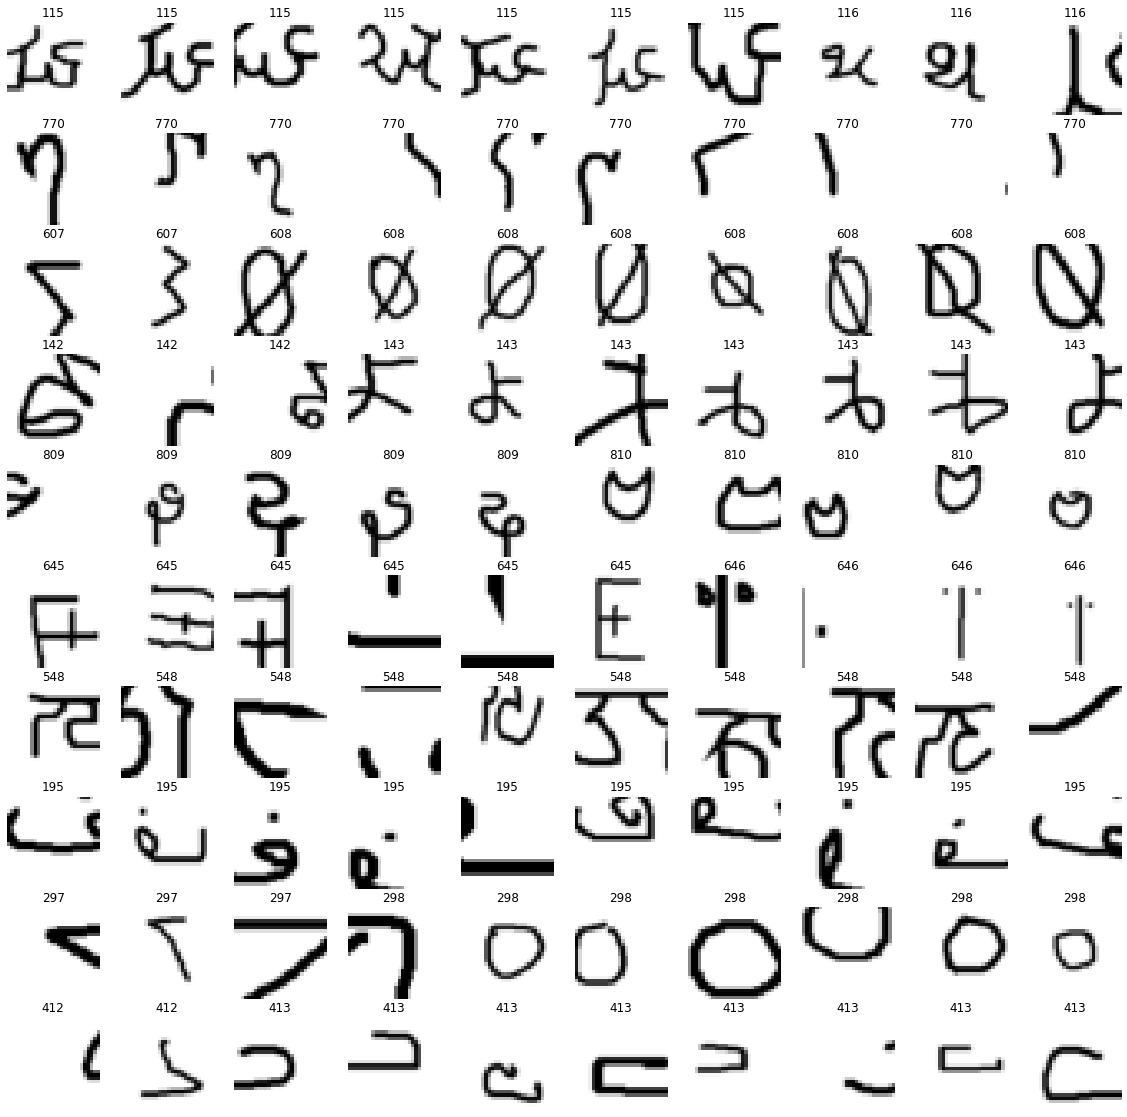

In [5]:
"""Iterate through dataset with transforms"""

import matplotlib.pyplot as plt
import numpy as np

ntrain = len(train_set) # 6000
idxs = np.random.choice(ntrain-10, 10)
fig, axs = plt.subplots(10,10, figsize=(20,20))
for i, idx in enumerate(idxs):
    for j in range(10):
        x, y = train_set[idx+j]
        axs[i][j].imshow(x.cpu().detach().permute(1,2,0).numpy())
        axs[i][j].axis('off')
        axs[i][j].set_title(str(y))
plt.show()

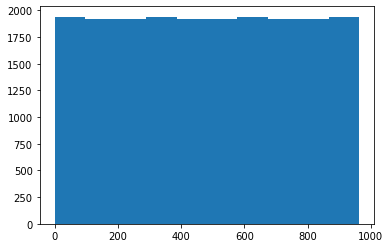

In [6]:
ys = [train_set[i][1] for i in range(len(train_set))]
plt.hist(ys)
plt.show()

In [7]:
N_WAY = 20  # Number of classes in a task
N_SHOT = 10  # Number of images per class in the support set
N_QUERY = 5  # Number of images per class in the query set
N_EVALUATION_TASKS = 100

# The sampler needs a dataset with a "get_labels" method. Check the code if you have any doubt!
test_set.get_labels = lambda: [
    instance[1] for instance in test_set._flat_character_images
]
test_sampler = TaskSampler(
    test_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS
)

test_loader = DataLoader(
    test_set,
    batch_sampler=test_sampler,
    num_workers=12,
    pin_memory=True,
    collate_fn=test_sampler.episodic_collate_fn,
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


example_support_images torch.Size([200, 3, 28, 28])
example_support_labels torch.Size([200])
example_query_images torch.Size([100, 3, 28, 28])
example_query_labels torch.Size([100])
example_class_ids 20


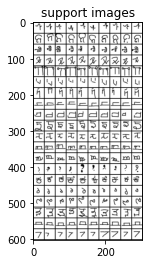

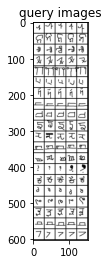

In [8]:
### VISUALIZE
(
    example_support_images,
    example_support_labels,
    example_query_images,
    example_query_labels,
    example_class_ids,
) = next(iter(test_loader))

def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]

for i in (
    example_support_images,
    example_support_labels,
    example_query_images,
    example_query_labels,
    example_class_ids,
):
    x=[]
    if type(i)==list:
        x.append(len(i))
    else:
        x.append(i.shape)
    print(namestr(i, globals())[1], *x)

    
plot_images(example_support_images, "support images", images_per_row=N_SHOT)
plot_images(example_query_images, "query images", images_per_row=N_QUERY)

In [9]:
from pathlib import Path
from torch.utils.data import Dataset
# from torchvision.io import read_image
from PIL import Image


class CustomDataset(Dataset):
    @staticmethod
    def _validate_root_dir(root):
        # todo: raise exception or warning
        pass
    
    @staticmethod
    def _validate_train_flag(train: bool, val: bool, test: bool):
        assert [train, val, test].count(True)==1, "one of train, valid & test must be true."        
        
    def __init__(self, root,
                 train: bool = False, val: bool = False, test: bool = False,
                 transform=None, target_transform=None,):

        self._validate_root_dir(root)
        self._validate_train_flag(train, val, test)        
        self.transform = transform
        self.target_transform = target_transform
        if train:
            self.data_dir = Path(root)/'train'
        elif val:
            self.data_dir = Path(root)/'val'
        elif test:
            self.data_dir = Path(root)/'test'        
    
        self._image_paths = sorted(
            list(self.data_dir.glob("**/*.jpg"))+
            list(self.data_dir.glob("**/*.jpeg"))+
            list(self.data_dir.glob("**/*.png")))
        self._image_labels = [int(i.parent.name) for i in self._image_paths]
        assert len(self._image_paths)==len(self._image_labels)
        
    def __len__(self):
        return len(self._image_paths)
    
    def __getitem__(self, idx):
        x = Image.open(str(self._image_paths[idx])).convert("L")## grayscale
        y = self._image_labels[idx]
        if self.transform:
            x = self.transform(x)
        if self.target_transform:
            y = self.target_transform(x)
        return x, y
    
    def get_labels(self):
        return self._image_labels

In [10]:
import matplotlib.pyplot as plt
import numpy as np

In [11]:
from torchvision.transforms import ToTensor

new_shape = (128,128)
# image_size = (64, 64)
ds_train = CustomDataset('/content/drive/Shareddrives/2022 데이터 청년 캠퍼스/pest', train=True, transform=transforms.Compose([transforms.Grayscale(num_output_channels=3), transforms.Resize(new_shape),transforms.ToTensor(), ]))
ds_valid = CustomDataset('/content/drive/Shareddrives/2022 데이터 청년 캠퍼스/pest', val=True, transform=transforms.Compose([transforms.Grayscale(num_output_channels=3), transforms.Resize(new_shape),transforms.ToTensor(), ]))
ds_test  = CustomDataset('/content/drive/Shareddrives/2022 데이터 청년 캠퍼스/pest', test=True, transform=transforms.Compose([transforms.Grayscale(num_output_channels=3) ,transforms.Resize(new_shape),transforms.ToTensor() ]))

 # need to add resize transform 
# for ds in [ds_train, ds_valid, ds_test]:
#     x, y = ds[380]
#     im = x.detach().cpu().permute(1,2,0).numpy()
#     plt.imshow(im)
#     plt.title(f"Label: {y}\nShape: {im.shape}")
#     plt.axis('off')
#     plt.show()

In [ ]:
# """Iterate through dataset with transforms"""

# import matplotlib.pyplot as plt
# import numpy as np

# ntrain = len(ds_train) # 6000
# idxs = np.random.choice(ntrain-10, 10)
# fig, axs = plt.subplots(10,10, figsize=(20,20))
# for i, idx in enumerate(idxs):
#     for j in range(10):
#         x, y = ds_train[idx+j]
#         axs[i][j].imshow(x.cpu().detach().permute(1,2,0).numpy())
#         axs[i][j].axis('off')
#         axs[i][j].set_title(str(y))
# plt.show()

In [40]:
## 오류


i = 0

while(True):
  if not ds_test[i][0].size() == torch.Size([3, 128, 128]):
    print(ds_test[i][0].size())
    print(i)

  i+=1

IndexError: ignored

In [42]:
# from operator import countOf
# import torch

i = 0
# k = list[][10]
# fig, axs = plt(1,1, figsize=(20,20))

k = 0
count = 1
label = 0

for i in range(len(ds_test)):
  if k == ds_test[i][1]:
    count = count+1
  else:
    label = label + 1
    print(label, "AND", count)
    count = 1
    k = ds_test[i][1]
    
 




  

1 AND 1
2 AND 3
3 AND 3
4 AND 3
5 AND 3
6 AND 3
7 AND 3
8 AND 3
9 AND 3
10 AND 3
11 AND 3
12 AND 3
13 AND 3
14 AND 3
15 AND 3
16 AND 3
17 AND 3
18 AND 3
19 AND 3
20 AND 3
21 AND 3
22 AND 3
23 AND 3
24 AND 3
25 AND 3
26 AND 3
27 AND 3
28 AND 3
29 AND 3
30 AND 3
31 AND 3
32 AND 3
33 AND 3
34 AND 3
35 AND 3
36 AND 3
37 AND 3
38 AND 3
39 AND 3
40 AND 3
41 AND 3
42 AND 3
43 AND 3


In [ ]:
# i = 0

# while(True):
#   if not ds_train[i][0].size() == torch.Size([3, 128, 128]):
#     print(ds_train[i][0].size())
#     print(i)

#   # i+=1

In [61]:
### NOTE: SAMPLE SIZE!! Must be less than population size.
N_WAY =40  # Number of classes in a task
N_SHOT = 5  # Number of images per class in the support set
N_QUERY = 5  # Number of images per class in the query set
N_EVALUATION_TASKS = 100

train_sampler = TaskSampler(
    ds_train, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS
)

train_loader = DataLoader(
    ds_train,
    batch_sampler=train_sampler,
    # num_workers=12,
    pin_memory=True,
    collate_fn=train_sampler.episodic_collate_fn,
)

example_support_images torch.Size([200, 3, 128, 128])
example_support_labels torch.Size([200])
example_query_images torch.Size([200, 3, 128, 128])
example_query_labels torch.Size([200])
example_class_ids 40


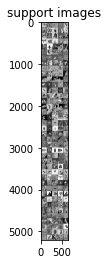

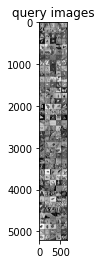

In [62]:
### VISUALIZE
(
    example_support_images,
    example_support_labels,
    example_query_images,
    example_query_labels,
    example_class_ids,
) = next(iter(train_loader))
def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]

for i in (
    example_support_images,
    example_support_labels,
    example_query_images,
    example_query_labels,
    example_class_ids,
):
    x=[]
    if type(i)==list:
        x.append(len(i))
    else:
        x.append(i.shape)
    print(namestr(i, globals())[1], *x)
    
plot_images(example_support_images, "support images", images_per_row=N_SHOT)
plot_images(example_query_images, "query images", images_per_row=N_QUERY)

In [65]:
class PrototypicalNetworks(nn.Module):
    def __init__(self, backbone: nn.Module):
        super(PrototypicalNetworks, self).__init__()
        self.backbone = backbone

    def forward(
        self,
        support_images: torch.Tensor,
        support_labels: torch.Tensor,
        query_images: torch.Tensor,
    ) -> torch.Tensor:
        """
        Predict query labels using labeled support images.
        """
        # Extract the features of support and query images
        z_support = self.backbone.forward(support_images)
        z_query = self.backbone.forward(query_images)

        # Infer the number of different classes from the labels of the support set
        n_way = len(torch.unique(support_labels))
        # Prototype i is the mean of all instances of features corresponding to labels == i
        z_proto = torch.cat(
            [
                z_support[torch.nonzero(support_labels == label)].mean(0)
                for label in range(n_way)
            ]
        )

        # Compute the euclidean distance from queries to prototypes
        dists = torch.cdist(z_query, z_proto)

        # And here is the super complicated operation to transform those distances into classification scores!
        scores = -dists
        return scores


convolutional_network = resnet18(pretrained=True)
convolutional_network.fc = nn.Flatten()
print(convolutional_network)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = PrototypicalNetworks(convolutional_network).cuda()
model = PrototypicalNetworks(convolutional_network).to(device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [67]:
N_TRAINING_EPISODES = 100
N_VALIDATION_TASKS = 10

train_sampler = TaskSampler(
    ds_train, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_TRAINING_EPISODES
)
train_loader = DataLoader(
    ds_train,
    batch_sampler=train_sampler,
    # num_workers=12,
    pin_memory=True,
    collate_fn=train_sampler.episodic_collate_fn,
)

In [20]:
def evaluate_on_one_task(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> [int, int]:
    """
    Returns the number of correct predictions of query labels, and the total number of predictions.
    """

    return (
        torch.max(
#             model(support_images.cuda(), support_labels.cuda(), query_images.cuda())
            model(support_images.to(device), support_labels.to(device), query_images.to(device))
            .detach()
            .data,
            1,
        )[1]
        == query_labels.to(device)#.cuda()
    ).sum().item(), len(query_labels)


def evaluate(data_loader: DataLoader):
    # We'll count everything and compute the ratio at the end
    total_predictions = 0
    correct_predictions = 0

    # eval mode affects the behaviour of some layers (such as batch normalization or dropout)
    # no_grad() tells torch not to keep in memory the whole computational graph (it's more lightweight this way)
    model.eval()
    with torch.no_grad():
        for episode_index, (
            support_images,
            support_labels,
            query_images,
            query_labels,
            class_ids,
        ) in tqdm(enumerate(data_loader), total=len(data_loader)):

            correct, total = evaluate_on_one_task(
                support_images, support_labels, query_images, query_labels
            )

            total_predictions += total
            correct_predictions += correct

    print(
        f"Model tested on {len(data_loader)} tasks. Accuracy: {(100 * correct_predictions/total_predictions):.2f}%"
    )


evaluate(train_loader)

100%|██████████| 300/300 [17:40<00:00,  3.54s/it]

Model tested on 300 tasks. Accuracy: 39.88%


40 way 5 / 5 기준  / N_TRAINING_EPISODES = 100 (모델 새롭게 다시 받아옴)

In [68]:
evaluate(train_loader)

100%|██████████| 100/100 [27:13<00:00, 16.33s/it]

Model tested on 100 tasks. Accuracy: 20.43%


In [ ]:
model.eval()
example_scores = model(
    example_support_images.to(device), #.cuda(),
    example_support_labels.to(device),#.cuda(),
    example_query_images.to(device), #.cuda(),
).detach()

_, example_predicted_labels = torch.max(example_scores.data, 1)

print("Ground Truth / Predicted")
for i in range(len(example_query_labels)):
    print(
        f"{ds_train._image_labels[example_class_ids[example_query_labels[i]]]} / {ds_train._image_labels[example_class_ids[example_predicted_labels[i]]]}"
    )

In [ ]:
def evaluate_on_one_task(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
):# -> [float, float]:
    """
    Returns the number of correct predictions of query labels, and the total number of predictions.
    """
    return (
        torch.max(
#             model(support_images.cuda(), support_labels.cuda(), query_images.cuda())
            model(support_images.to(device), support_labels.to(device), query_images.to(device))
            .detach()
            .data,
            1,
        )[1]
        == query_labels.to(device)#.cuda()
    ).sum().item(), len(query_labels)


def evaluate(data_loader: DataLoader):
    # We'll count everything and compute the ratio at the end
    total_predictions = 0
    correct_predictions = 0

    # eval mode affects the behaviour of some layers (such as batch normalization or dropout)
    # no_grad() tells torch not to keep in memory the whole computational graph (it's more lightweight this way)
    model.eval()
    with torch.no_grad():
        for episode_index, (
            support_images,
            support_labels,
            query_images,
            query_labels,
            class_ids,
        ) in tqdm(enumerate(data_loader), total=len(data_loader)):

            correct, total = evaluate_on_one_task(
                support_images, support_labels, query_images, query_labels
            )

            total_predictions += total
            correct_predictions += correct

    print(
        f"Model tested on {len(data_loader)} tasks. Accuracy: {(100 * correct_predictions/total_predictions):.2f}%"
    )


evaluate(ds_train)

In [ ]:
data_loader

In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


def fit(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> float:
    optimizer.zero_grad()
    classification_scores = model(
#         support_images.cuda(), support_labels.cuda(), query_images.cuda()
        support_images.to(device), support_labels.to(device), query_images.to(device)
    )

    loss = criterion(classification_scores, query_labels.to(device))#query_labels.cuda())
    loss.backward()
    optimizer.step()

    return loss.item()

In [ ]:
# Train the model yourself with this cell

log_update_frequency = 10

all_loss = []
model = model.train()
with tqdm(enumerate(train_loader), total=len(train_loader)) as tqdm_train:
    for episode_index, (
        support_images,
        support_labels,
        query_images,
        query_labels,
        _,
    ) in tqdm_train:
        loss_value = fit(support_images, support_labels, query_images, query_labels)
        all_loss.append(loss_value)

        if episode_index % log_update_frequency == 0:
            tqdm_train.set_postfix(loss=sliding_average(all_loss, log_update_frequency))
            
# print(
#         f"Model tested on {len(data_loader)} tasks. Accuracy: {(100 * correct_predictions/total_predictions):.2f}%"
#     )

  1%|          | 1/100 [00:44<1:14:11, 44.96s/it, loss=2.87]

test

In [38]:
### NOTE: SAMPLE SIZE!! Must be less than population size.
N_WAY =10  # Number of classes in a task
N_SHOT = 2  # Number of images per class in the support set
N_QUERY = 1 # Number of images per class in the query set
N_EVALUATION_TASKS = 100

test_sampler = TaskSampler(
    ds_test, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS
)

test_loader = DataLoader(
    ds_test,
    batch_sampler=test_sampler,
    # num_workers=12,
    pin_memory=True,
    collate_fn=test_sampler.episodic_collate_fn,
)

In [37]:
evaluate(test_loader)

100%|██████████| 100/100 [02:31<00:00,  1.52s/it]

Model tested on 100 tasks. Accuracy: 43.10%


In [58]:
### NOTE: SAMPLE SIZE!! Must be less than population size.
N_WAY =10  # Number of classes in a task
N_SHOT = 1  # Number of images per class in the support set
N_QUERY = 1 # Number of images per class in the query set
N_EVALUATION_TASKS = 100


val_sampler = TaskSampler(
    ds_valid, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS
)

val_loader = DataLoader(
    ds_valid,
    batch_sampler = val_sampler,
    # num_workers=12,
    pin_memory=True,
    collate_fn=val_sampler.episodic_collate_fn,
)

In [59]:

(
    example_support_images,
    example_support_labels,
    example_query_images,
    example_query_labels,
    example_class_ids,
) = next(iter(val_loader))


def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]

for i in (
    example_support_images,
    example_support_labels,
    example_query_images,
    example_query_labels,
    example_class_ids,
):
    x=[]
    if type(i)==list:
        x.append(len(i))
    else:
        x.append(i.shape)
    print(namestr(i, globals())[1], *x)
plot_images(example_support_images, "support images", images_per_row=N_SHOT)
plot_images(example_query_images, "query images", images_per_row=N_QUERY)

ValueError: ignored

In [43]:
evaluate(val_loader)

NameError: ignored